<a href="https://colab.research.google.com/github/abuchin/ML_protein_ligand_prediction/blob/main/ML_protein_binnding_data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of binding affinity for UniPort proteins for various ligands

In this Notebook we explore the dataset (Deloitte_Drug_Discovery_dataset.csv). This dataset contains the list of Uniport IDs for various proteins, lingands chem ids for ligands and lignad binding affinity measured by kiba_score.  In this Notebook we perform the following:

1) Exploratory data analysis and data cleaning (removing duplicates)

2) Expand the datasset for negative samples

3) Extract features for Uniprot proteins (https://www.uniprot.org/) from UniRep and features for Pub Chem ligands (https://pubchem.ncbi.nlm.nih.gov/).

4) We form the dataset for ML model.

# Import libaries

In [ ]:

# Install missing modules
!pip install rdkit --quiet
!pip install pubchempy --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 66.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:

 # Data Science libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import requests

# Get ML libraries
from transformers import AutoTokenizer, AutoModel
import torch

# data manipulation
import pickle

# parallel library
from concurrent.futures import ProcessPoolExecutor, as_completed

# add time to measure speed
import time

# Get RDkit libraries
from rdkit import Chem
from rdkit.Chem import AllChem
import pubchempy as pcp
from rdkit.Chem import AllChem, rdMolDescriptors, Descriptors


In [ ]:

# save requirements
!pip freeze > requirements_data_prep.txt


# Import the data

In [ ]:

# read the data (test)
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/Deloitte_DrugDiscovery_dataset.csv')
# show the data
data.head(5)


,UniProt_ID,pubchem_cid,kiba_score,kiba_score_estimated
0,A0A0B4J268,7428.0,21400.0,True
1,A0A0B4J268,65303.0,21300.0,True
2,A0A0B4J268,96506.0,21400.0,True
3,A0A0B4J268,174326.0,21300.0,True
4,A0A0B4J268,225906.0,7910.0,True


# **Problem** : Some values are TRUE "kiba_score_estimated", but have the kiba_score.

**Assumption:** only values with "kiba_score_estimated" == True are valid data points, where kiba score has been estimated.

**Solution:** we will keep only these values for model training and evaluation.


In [ ]:

# keep only reliably estimated values
data=data[data['kiba_score_estimated']==True]


## Checking data consistency

In [ ]:

# basic properties
n_points=data.shape[0]
n_features=data.shape[1]
print(f'Number of points: {n_points}')
print(f'Number of features: {n_features}')


Number of points: 1076648
Number of features: 4


In [ ]:

n_unique_uniport=data['UniProt_ID'].nunique()
print(f'Number of unique UniPort IDs: {n_unique_uniport}')
n_unique_pubchem=len(np.unique(data['pubchem_cid']))
print(f'Number of unique PubChem IDs: {n_unique_pubchem}')


Number of unique UniPort IDs: 4340
Number of unique PubChem IDs: 652280


**Drop NaN values**

**Problem:** There are values that are NaN in Uniprot_ID, pubchem_cid or kiba_score. We would not be able to use these values for model training, so we would remove them.

**Solution:** We make an assumption that these values could not be properly estimated. Therefore we will remove these rows from out dataset


In [ ]:

print('Original dataset')
print(data.shape)
print('No NaN dataset')
print(data.dropna().shape)

# remove the NaNs from the shuffled data
data=data.dropna()


Original dataset
(1076648, 4)
No NaN dataset
(1064928, 4)


#### Finding the duplicates

Problem: Duplicates in the dataset could decrease the model perforance down the line. First we find the duplicates and estimatate the amount of them in the dataset.

In [ ]:

# Find duplicates based on UniProt_ID and pubchem_cid
duplicates = data[data.duplicated(subset=['UniProt_ID', 'pubchem_cid'], keep=False)]

# Display the duplicate rows
print("Duplicate pairs based on UniProt_ID and pubchem_cid:")
print(duplicates.shape)
duplicates.head(5)


Duplicate pairs based on UniProt_ID and pubchem_cid:
(45116, 4)


,UniProt_ID,pubchem_cid,kiba_score,kiba_score_estimated
725,B0BNF9,56840672.0,11100.000,True
726,B0BNF9,56840672.0,11100.000,True
922,C7C422,118256794.0,0.497,True
923,C7C422,118256794.0,0.314,True
1007,C7C422,118257183.0,1.950,True


**Showing kiba score for multiple proteins (scores for multiple ligands)**

---



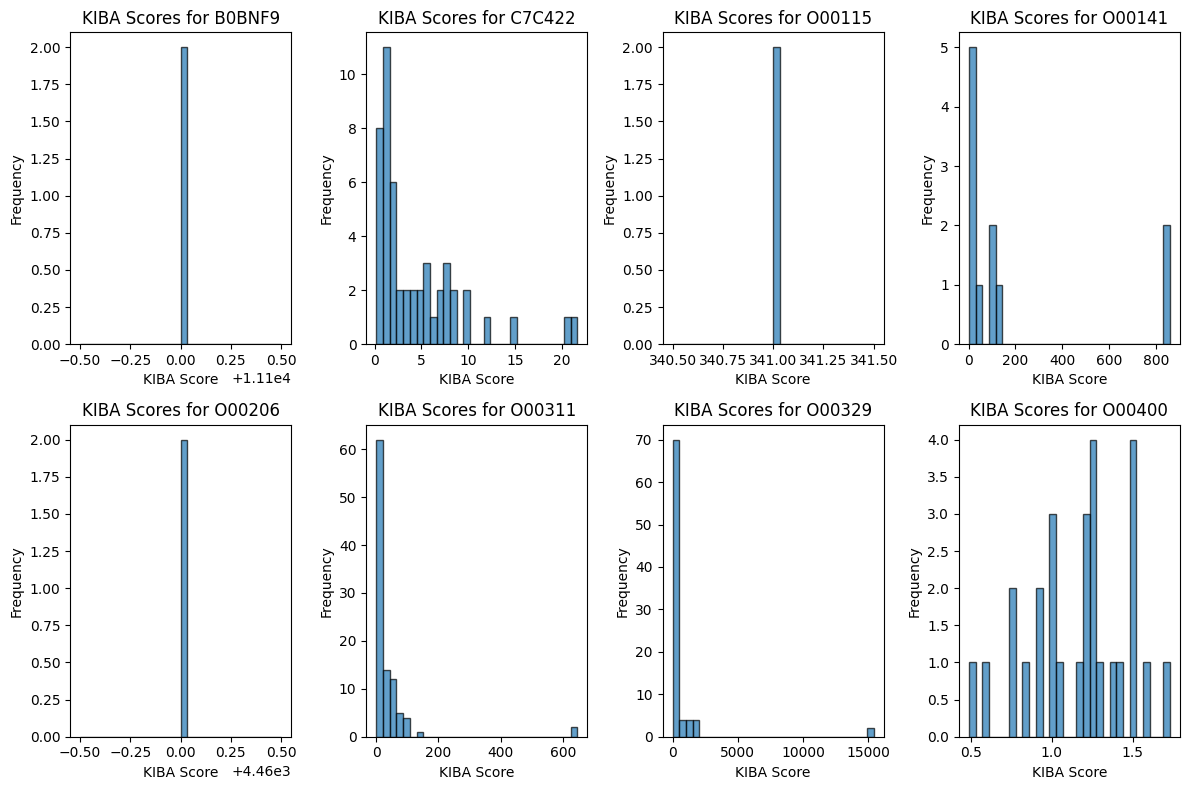

In [ ]:

# get values for unique samples
UniProt_ID_unique=np.unique(duplicates['UniProt_ID'].values)

# Plot kiba_score for multiple unique UniPort
n_sample=[0, 1, 2, 3 ,4, 5, 6, 7]

fig, axes = plt.subplots(2, 4, figsize=(12, 8))

# Flatten axes for easy indexing in the loop
axes = axes.flatten()

# Plot values for 4 scores
for i, sample in enumerate(n_sample):
    # Filter the data for the specific UniProt_ID
    data_to_plot = duplicates[duplicates['UniProt_ID'] == UniProt_ID_unique[sample]]['kiba_score'].values
    # Plot the histogram in the corresponding subplot
    axes[i].hist(data_to_plot, bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_xlabel('KIBA Score')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'KIBA Scores for {UniProt_ID_unique[sample]}')
# no overlap
plt.tight_layout()


### **Problem:** there are multiple pairs of UniProt_ID x pubchem_cid

**Assumption:** Different values for UniProt_ID x pubchem_cid pair correspond to multiple experimental measures.

**Solution:** Since there are multiple measurements per protein x ligand pair, we assume these experiments contain equally valuable data in every experiment. Theferefore we will average these measurements per Uniprot_ID x pubchem_id value to estimate the average kiba_score from every experiment.

In [ ]:

# Calculate the mean kiba_score for each pair and assign it back to each row in the group
data['kiba_score_mean'] = data.groupby(['UniProt_ID', 'pubchem_cid'])['kiba_score'].transform('mean')

# Drop the original kiba_score column and remove duplicates based on unique pairs
data_unique = data.drop(columns='kiba_score').drop_duplicates(subset=['UniProt_ID', 'pubchem_cid']).rename(columns={'kiba_score_mean': 'kiba_score'})

# Display the result
print(data_unique)


         UniProt_ID  pubchem_cid kiba_score_estimated  kiba_score
0        A0A0B4J268       7428.0                 True     21400.0
1        A0A0B4J268      65303.0                 True     21300.0
2        A0A0B4J268      96506.0                 True     21400.0
3        A0A0B4J268     174326.0                 True     21300.0
4        A0A0B4J268     225906.0                 True      7910.0
...             ...          ...                  ...         ...
1134632      Q9ZLT0  135992859.0                 True      2220.0
1134633      Q9ZLT0  136059714.0                 True      3570.0
1134634      Q9ZLT0  136059715.0                 True     12100.0
1134635      Q9ZLT0  136059716.0                 True      2480.0
1134636      Q9ZLT0  136237280.0                 True       317.0

[1042216 rows x 4 columns]


In [ ]:

# check for duplicates in the data
has_duplicates = data_unique.duplicated(subset=['UniProt_ID', 'pubchem_cid']).any()
print('Are there duplicates?')
print(has_duplicates)


Are there duplicates?
False


### **Problem:** there are is small amount of negative contols

**Assumption:** We have found that mostly positive binding values (kiba_score > 0) are found in the dataset. Negative controls (not bound values) are not present.

**Solution:** We will shuffle Uniport ID and Chem ID to create synthetic dataset with negative bindings. This will create an equal size dataset with negative bindings to ballance the "positive" dataset with positive bindings values from experiments.

**Distribution of kiba_scores**

In [ ]:

# find median for kiba_score
median_thr = np.median(data_unique['kiba_score'].values)
print('Mean value of kiba_score')
print(median_thr)


Mean value of kiba_score
179.0


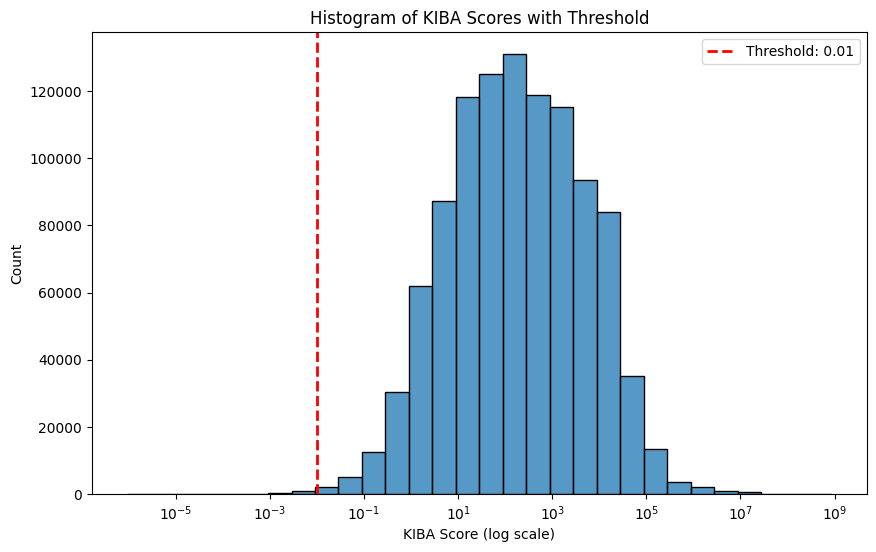

In [ ]:

# Calculate the median threshold for the KIBA score
thr = 0.01

# Create the histogram with log scale on the horizontal axis
plt.figure(figsize=(10, 6))
sns.histplot(data_unique['kiba_score'], bins=30, log_scale=(True, False))
plt.axvline(thr, color='red', linestyle='dashed', linewidth=2, label=f'Threshold: {thr:.2f}')
plt.xlabel('KIBA Score (log scale)')
plt.title('Histogram of KIBA Scores with Threshold')
plt.legend()
plt.show()


**Kiba score encoding**

In order to ensure bound and not bound targets are present in our dataset, we have added kiba_scores based on medians.

**Binding encoding:** 0 - not bound, 1 - bound.

In [ ]:

# MANUAL THRESHOLD

# Add label for bounded based on median
# 0 - not found, 1 - bound
data_unique['bound'] = (data_unique['kiba_score'] > 0).astype(int)


In [ ]:

# create negative data by shuffling
data_negative = data_unique.copy()

# shuffle only pubchem_id, preserve the order for uniport
data_negative['pubchem_cid'] = np.random.permutation(data_negative['pubchem_cid'].values)

# set kiba score for zero (synthetic negative samples)

# added kiba_score as higher than medium -> not bound
data_negative['kiba_score']= 0
data_negative['kiba_score_estimated']=False

# make sure these pairs are negative
data_negative['bound']=0

# show results
print('Negative samples')
print(data_negative.head(5))
print()
print('Positive samples')
print(data_unique.head(5))



Negative samples
   UniProt_ID  pubchem_cid  kiba_score_estimated  kiba_score  bound
0  A0A0B4J268  118620117.0                 False           0      0
1  A0A0B4J268  155566994.0                 False           0      0
2  A0A0B4J268  155560069.0                 False           0      0
3  A0A0B4J268  118753751.0                 False           0      0
4  A0A0B4J268   75180736.0                 False           0      0

Positive samples
   UniProt_ID  pubchem_cid kiba_score_estimated  kiba_score  bound
0  A0A0B4J268       7428.0                 True     21400.0      1
1  A0A0B4J268      65303.0                 True     21300.0      1
2  A0A0B4J268      96506.0                 True     21400.0      1
3  A0A0B4J268     174326.0                 True     21300.0      1
4  A0A0B4J268     225906.0                 True      7910.0      1


### Filter out randomly occuring protein to ligand pairs

**Problem:** After random shuffling there is a chance that some pairs in negative will be assigned 0, while they have been measured in the original dataset. This would create the duplicates and make the data inconsistent.

**Solution:** We will find all intersections between positive and negative parirs of proteins and ligands and remove these pairs from data_negative.

In [ ]:

# check if there are no randomly occuring pairs due to random shuffling
positive_pairs = set(tuple(x) for x in data_unique[['UniProt_ID', 'pubchem_cid']].to_numpy())
negative_pairs = set(tuple(x) for x in data_negative[['UniProt_ID', 'pubchem_cid']].to_numpy())

# find common pairs
common_pairs = positive_pairs.intersection(negative_pairs)

# check if the intersection is empty
if len(common_pairs) == 0:
       print("No randomly occurring pairs found.")
else:
  print(f"Found {len(common_pairs)} randomly occurring pairs:")
  print(common_pairs)



Found 8713 randomly occurring pairs:
{('P53667', 5330790.0), ('P27338', 137640020.0), ('P49768', 127028397.0), ('P00533', 66838546.0), ('P04626', 216239.0), ('P35916', 11712649.0), ('P50750', 3038525.0), ('O60885', 164616886.0), ('Q9Y6E0', 9926054.0), ('P10635', 54582019.0), ('P35968', 88876306.0), ('P00915', 71459903.0), ('P28482', 44143534.0), ('O43570', 164624049.0), ('P48736', 42642645.0), ('P29274', 155534836.0), ('P35968', 16678439.0), ('P11309', 44551653.0), ('P23975', 46701015.0), ('Q02750', 25126798.0), ('P53779', 5281628.0), ('Q06187', 5494449.0), ('P23458', 9884685.0), ('P42336', 24905145.0), ('P00915', 162674412.0), ('P29474', 12778904.0), ('P10721', 156414.0), ('Q9ULX7', 20161.0), ('P22607', 9933475.0), ('O14965', 58056356.0), ('Q16790', 156017797.0), ('Q9BY41', 45141751.0), ('Q9UBF8', 176870.0), ('Q16790', 126508295.0), ('Q9UM73', 25184036.0), ('P19784', 4908365.0), ('P07949', 5494449.0), ('P35968', 155545755.0), ('P42336', 137453918.0), ('P12931', 17755052.0), ('P30543',

**Note on negative pairs**

**Caution:** We have swapped the UniProt_Ids and pubchem_ids to derive synthetic negative samples. In these computations we assumed that the binding, kiba_score would be 0 for these samples. Since these pairs were not necesserily measured, we essentially make a prediction for these scores. If binding would be find for these pairs, kiba_score > 0, the training data should be changed accordingly.

In [ ]:

# Convert common_pairs to a list of lists for easier filtering
common_pairs_list = [list(pair) for pair in common_pairs]

# Filter data_negative using a boolean mask
data_negative_filtered = data_negative[~data_negative[['UniProt_ID', 'pubchem_cid']].apply(tuple, axis=1).isin(common_pairs)]


In [ ]:

# check again that there are no negative pairs in filtered dataset
positive_pairs = set(tuple(x) for x in data_unique[['UniProt_ID', 'pubchem_cid']].to_numpy())

# Create a set of negative pairs from the filtered DataFrame
negative_pairs_filtered = set(tuple(x) for x in data_negative_filtered[['UniProt_ID', 'pubchem_cid']].to_numpy())

# Find the intersection
common_pairs_filtered = positive_pairs.intersection(negative_pairs_filtered)

# Check if the intersection is empty
if len(common_pairs_filtered) == 0:
    print("No randomly occurring pairs found in data_negative_filtered.")
else:
    print(f"Found {len(common_pairs_filtered)} randomly occurring pairs in data_negative_filtered:")
    print(common_pairs_filtered)


No randomly occurring pairs found in data_negative_filtered.


**Create training dataset**

**Assumption:** We assume that about 50% of the proteins in the dataset have not bound with these ligands. Therefore we could add negative samples that were not found previously in the dataset.

In this part we combine the positive and negative datasets. The resulting protein to ligand pairs will have unique protein and ligand values and kiba_scores.

In [ ]:

# Concatenate the two DataFrames
combined_data = pd.concat([data_unique, data_negative_filtered], ignore_index=True)
# Display the result
print(combined_data)


         UniProt_ID  pubchem_cid kiba_score_estimated  kiba_score  bound
0        A0A0B4J268       7428.0                 True     21400.0      1
1        A0A0B4J268      65303.0                 True     21300.0      1
2        A0A0B4J268      96506.0                 True     21400.0      1
3        A0A0B4J268     174326.0                 True     21300.0      1
4        A0A0B4J268     225906.0                 True      7910.0      1
...             ...          ...                  ...         ...    ...
2074614      Q9ZLT0   10764526.0                False         0.0      0
2074615      Q9ZLT0   24825394.0                False         0.0      0
2074616      Q9ZLT0    5280682.0                False         0.0      0
2074617      Q9ZLT0   66803732.0                False         0.0      0
2074618      Q9ZLT0   57333717.0                False         0.0      0

[2074619 rows x 5 columns]


In [ ]:

# shuffle the order of rows in the dataframe
shuffled_data = combined_data.sample(frac=1, random_state=37).reset_index(drop=True)
# show the dataset
shuffled_data


,UniProt_ID,pubchem_cid,kiba_score_estimated,kiba_score,bound
0,P27338,71504248.0,True,28600.000,1
1,P25099,122622803.0,False,0.000,0
2,P15538,6539787.0,True,85.100,1
3,P33905,44444023.0,False,0.000,0
4,P97266,50994529.0,True,39.900,1
...,...,...,...,...,...
2074614,P53051,139030.0,False,0.000,0
2074615,P49286,67353824.0,True,0.145,1
2074616,Q9NWZ3,10458325.0,True,746.000,1
2074617,P0DMS8,16094554.0,True,84.400,1


**Distribution of bound vs not bound**

We need to ensure that our dataset is balanced. I.e. it contains similar number of bound and not bound protein to ligand pairs.

Text(0.5, 1.0, 'Histogram of Bound vs. Not Bound')

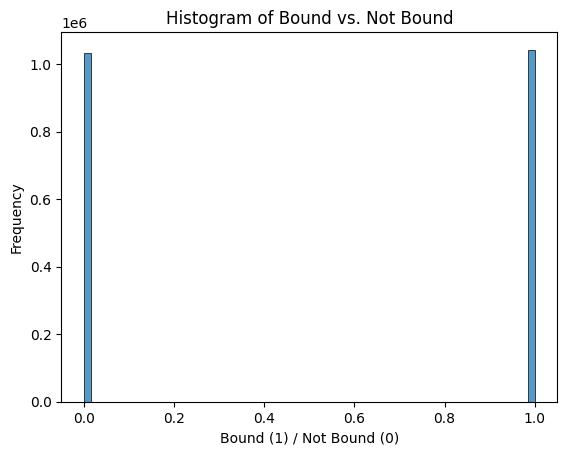

In [ ]:

# Create the histogram using seaborn
sns.histplot(x=shuffled_data['bound'])  # Use histplot for histogram

# Set plot labels and title
plt.xlabel('Bound (1) / Not Bound (0)')  # Update x-axis label
plt.ylabel('Frequency')  # Add y-axis label
plt.title('Histogram of Bound vs. Not Bound')  # Update title


In [ ]:

# save intermediate results
shuffled_data.to_csv('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/combined_data.csv', index=False)


In [ ]:
# reload data
shuffled_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/combined_data.csv')


# **Feature engineering**

In order to make this project we need to extract features from proteins and ligands to have the dataset input into ML models. We extract features for proteins and ligands separately.

1) In particular we will use ProtBert model (https://huggingface.co/Rostlab/prot_bert_bfd) representation for proteins from UniProt. This would allow to get low-dimensional representaitons of protein structure that would be used by ML models downstream.

2) For ligand representation we will use RDKIT (https://www.rdkit.org/docs/GettingStartedInPython.html) to extract SMILES and molecular fingerprint representation for ligands.

These vectors will be then combined to formulate the training dataset for the models.

## *** Prepare the data: proteints ***

**Protein ebmeddings:** getting embeddings from Prot-Bert
kaggle challenge

**Problem:** Generating embeddings from Prot-Bert takes a lot of time, we need to speed things up.

**Alternative:** using already generated embeddings from Prot-Bert (Kaggle CAFA5):

https://www.kaggle.com/datasets/henriupton/protbert-embeddings-for-cafa5

In [ ]:

# get the data for ProtBert embeddings
bert_data_test=np.load('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/Pro_bert_test_embeddings.npy')
bert_data_train=np.load('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/Pro_bert_train_embeddings.npy')

# dictionary of IDs
bert_data_test_ids=np.load('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/Prot_Bert_test_ids.npy')
bert_data_train_ids=np.load('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/Prot_Bert_train_ids.npy')

# concatenate arrays
bert_data_ids=np.concatenate((bert_data_test_ids, bert_data_train_ids), axis=0)
bert_data=np.concatenate((bert_data_test, bert_data_train), axis=0)

# cobmine existing protein embeddings
protein_embeddings=dict(zip(bert_data_ids, bert_data))


### Compare two lists of datasets

Alarm: there are some proteins missing

In [ ]:

common_proteins = set(protein_embeddings.keys()).intersection(set(shuffled_data['UniProt_ID']))
num_common_proteins = len(common_proteins)
print('UnProt_id vs CIFAR Kaggle')
print()
print(f"Number of common proteins: {num_common_proteins}")
print()

different_proteins = set(np.unique(shuffled_data['UniProt_ID'].values)) - set(protein_embeddings.keys())
num_different_proteins = len(different_proteins)
print(f"Number of different proteins: {num_different_proteins}")



UnProt_id vs CIFAR Kaggle

Number of common proteins: 3977

Number of different proteins: 356


# Create a set of missed proteins using Prot-Bert model
(in progress)

This part of the code allows to detive Prot-Bert representation of a given protein. Based on UniProtID the model generates the amino acid sequence (fetch_protein_sequence), then this sequence is used to input into Prot-Bert model. The model representation is then used to represent the protein as a vector of 1024 length, where all proteins are being represented.

**Current problem:** model inference is very slow, need to optimize the inference time.

**Solution:** Moving model to CUDA allow only partially improve the inference speed.

**Using protein model for missing 357 proteins.**

Prot-Bert model to generate embeddings: helper functions

In [ ]:

def fetch_protein_sequence(uniprot_id):
    url = f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta"
    response = requests.get(url)
    if response.status_code == 200:
        fasta_data = response.text
        sequence = ''.join(fasta_data.split('\n')[1:])
        return sequence
    else:
        print(f"Error fetching sequence for {uniprot_id}")
        return None


def get_protein_embedding(sequence):

    # Tokenize the sequence
    inputs = tokenizer(sequence, return_tensors="pt", is_split_into_words=False, padding=True, truncation=True, add_special_tokens=True)

    # Move inputs to CUDA
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        embeddings = model(**inputs).last_hidden_state

    return embeddings


def get_protein_embedding_fixed(sequence, max_length=1024):
    """
    Generates a protein embedding from a given sequence using Prot-Bert.

    Args:
        sequence (str): The protein sequence.
        max_length (int, optional): The maximum sequence length for padding/truncation. Defaults to 1024.

    Returns:
        torch.Tensor: The protein embedding with a fixed size.
    """

    # Tokenize the sequence
    inputs = tokenizer(sequence, return_tensors="pt", is_split_into_words=False, padding='max_length', truncation=True, add_special_tokens=True, max_length=max_length)

    # Move inputs to CUDA
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        embeddings = model(**inputs).last_hidden_state

    # Mean pooling to get a fixed-size embedding
    embeddings = torch.mean(embeddings, dim=1)  # Average across the sequence dimension

    return embeddings



In [ ]:

# Initialize ProtBERT model and tokenizer and move model to CUDA
model_name = "Rostlab/prot_bert_bfd"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Move the model to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Example UniProt IDs and embedding storage
uniprot_ids = shuffled_data['UniProt_ID'].values

# Get unique values only for uniprot_ids
uniprot_ids = np.unique(uniprot_ids)

# create a list of missed protein embeddings
protein_embeddings_missed = {}


In [ ]:
# Generate embeddings: for all files

# convert different proteins to list
different_proteins_list = list(different_proteins)

start_time = time.time()

n_prots=50

for uniprot_id in different_proteins_list[:n_prots]:
    # Get amino acid sequence
    sequence = fetch_protein_sequence(uniprot_id)

    # Add spaces to the sequence for proper tokenization
    sequence = " ".join(sequence)

    if sequence:
        # Get embeddings
        embeddings = get_protein_embedding_fixed(sequence)

        # Move embeddings back to CPU and convert to numpy
        protein_embeddings_missed[uniprot_id] = embeddings.view(-1).cpu().numpy()
    else:
        print(f"No sequence found for UniProt_ID: {uniprot_id}")

end_time = time.time()

inference_time = end_time - start_time

print(f"Inference time: {inference_time} seconds" + ' ' + str(n_prots) + ' proteins')


Inference time: 309.4170949459076 seconds 50 proteins


In [ ]:

# save missed protein embeddings
# save to pickle
with open('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/protein_embeddings_missed.pkl', 'wb') as f:
    pickle.dump(protein_embeddings_missed, f)


**Save results for proteins**

In this part we save the intermediate results, the embeddings from the model.

In [ ]:

# save to pickle
with open('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/protein_embeddings.pkl', 'wb') as f:
    pickle.dump(protein_embeddings, f)


In [ ]:

# reload from pickle
with open('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/protein_embeddings.pkl', 'rb') as f:
    protein_embeddings = pickle.load(f)


## *** Prepare the data: ligands ***

### Parallel execution of pubchem_id

**Reading SMILES from files**

In this part of the Notebook we geenrate the representations for ligands using RDkit library. To accelerate the process we use pre-computed table between pubchem_id and smiles represetation of ligand structure. Then smiles is being used to extract chemical properties for every molecule.

**Problem:** To find the link between pubchem_id and SMILES and then fingerpring representation. It turned out that reading the data from file was much faster solution than using Python API. Python API was extremely slow (0.8 sec / pubchem_id ). To overcome this issue I have found this file with the knowledge of pubchem_CID.

I have found this file:
https://chemistry.stackexchange.com/questions/122109/how-to-get-the-smiles-of-all-compounds-on-pubchem

Using this data I have converted pubchem_id -> SMILES -> molecular properties.

In [ ]:

# read cid_smiles map
cid_smiles_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/CID-SMILES.txt', sep=None, engine='python', header=None)
cid_smiles_df.head(5)


,0,1
0,1,CC(=O)OC(CC(=O)[O-])C[N+](C)(C)C
1,2,CC(=O)OC(CC(=O)O)C[N+](C)(C)C
2,3,C1=CC(C(C(=C1)C(=O)O)O)O
3,4,CC(CN)O
4,5,C(C(=O)COP(=O)(O)O)N


In [ ]:

# add column headers
cid_smiles_df.columns = ['pubchem_cid', 'smiles']


**Improviing the speed**

To make the look-up for chemical cell ids faster we create cid_to_smiles dictionary.

In [ ]:

# get pubchem ids from shuffled data
pubchem_ids = np.unique(shuffled_data['pubchem_cid'].values)
pubchem_cids = list(pubchem_ids.astype(int))

# create a dictionary for cid to smiles
cid_to_smiles = dict(zip(cid_smiles_df['pubchem_cid'], cid_smiles_df['smiles']))


In [ ]:

# save dictionary
with open('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/cid_to_smiles.pkl', 'wb') as f:
    pickle.dump(cid_to_smiles, f)


In [ ]:

# reload the dictionary
with open('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/cid_to_smiles.pkl', 'rb') as f:
    cid_to_smiles = pickle.load(f)


**Parallel execution: ligands**

Since serial execution for ligands was very slow, we have written the processing in batches using ProcessPoolExecutor library.

In [ ]:

def process_ligand_batch(pub_ids):

    '''Function to process ligands in batches based on molecular cid'''

    batch_results = {}

    for pub_id in pub_ids:
        smiles = cid_to_smiles.get(pub_id, None)
        if smiles is None:
            continue

        # Convert SMILES to RDKit molecule object
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue  # Skip invalid molecules

        # Calculate molecular fingerprint and descriptors
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
        fingerprint_bits = list(fingerprint)

        # save all other parameters
        molecular_weight = Descriptors.MolWt(mol)
        logP = Descriptors.MolLogP(mol)
        polar_surface_area = Descriptors.TPSA(mol)
        num_rotatable_bonds = Descriptors.NumRotatableBonds(mol)
        num_h_donors = Descriptors.NumHDonors(mol)
        num_h_acceptors = Descriptors.NumHAcceptors(mol)
        num_aromatic_rings = Descriptors.NumAromaticRings(mol)
        fraction_csp3 = Descriptors.FractionCSP3(mol)
        bertz_complexity = Descriptors.BertzCT(mol)

        # Store results in dictionary for this batch
        batch_results[pub_id] = {
            'Fingerprint': fingerprint_bits,
            'SMILES': smiles,
            'MolecularWeight': molecular_weight,
            'LogP': logP,
            'PolarSurfaceArea': polar_surface_area,
            'NumRotatableBonds': num_rotatable_bonds,
            'NumHDonors': num_h_donors,
            'NumHAcceptors': num_h_acceptors,
            'NumAromaticRings': num_aromatic_rings,
            'FractionCSP3': fraction_csp3,
            'BertzComplexity': bertz_complexity
        }

    return batch_results


**Manually process dataset in batches**

The dataset processing was quite slow and the whole dataset did not fit into the memory. Therefore we have used half-manually processing of ligand data in ~100K batches.


pubchem_cids=pubchem_cids[:100_000]

pubchem_cids=pubchem_cids[100_000:200_000]

pubchem_cids=pubchem_cids[200_000:300_000]

pubchem_cids=pubchem_cids[300_000:400_000]

pubchem_cids=pubchem_cids[400_000:500_000]

pubchem_cids=pubchem_cids[500_000:]


In [ ]:

# Dictionary for batch of ligands
ligand_data_600 = {}

# Prepare pubchem IDs and SMILES mapping for faster access
pubchem_ids = np.unique(shuffled_data['pubchem_cid'].values)
pubchem_cids = list(pubchem_ids.astype(int))

# set up the last batch
pubchem_cids=pubchem_cids[500000:]

# Parallel execution with batch processing
start_time = time.time()
batch_size = 50  # Adjust batch size based on your system’s capabilities

# Split pubchem_cids into batches
batches = [pubchem_cids[i:i + batch_size] for i in range(0, len(pubchem_cids), batch_size)]

# Use ProcessPoolExecutor for parallel processing of batches
with ProcessPoolExecutor() as executor:
    futures = {executor.submit(process_ligand_batch, batch): batch for batch in batches}
    for future in as_completed(futures):
        result_batch = future.result()
        ligand_data_600.update(result_batch)  # Aggregate results into main dictionary

end_time = time.time()
print(f"Total time taken: {end_time - start_time} seconds")



Streaming output truncated to the last 5000 lines.
[02:37:25] DEPRECATION WARNING: please use MorganGenerator
[02:37:25] DEPRECATION WARNING: please use MorganGenerator
[02:37:25] DEPRECATION WARNING: please use MorganGenerator
[02:37:25] DEPRECATION WARNING: please use MorganGenerator
[02:37:25] DEPRECATION WARNING: please use MorganGenerator
[02:37:25] DEPRECATION WARNING: please use MorganGenerator
[02:37:25] DEPRECATION WARNING: please use MorganGenerator
[02:37:25] DEPRECATION WARNING: please use MorganGenerator
[02:37:25] DEPRECATION WARNING: please use MorganGenerator
[02:37:25] DEPRECATION WARNING: please use MorganGenerator
[02:37:25] DEPRECATION WARNING: please use MorganGenerator
[02:37:25] DEPRECATION WARNING: please use MorganGenerator
[02:37:25] DEPRECATION WARNING: please use MorganGenerator
[02:37:25] DEPRECATION WARNING: please use MorganGenerator
[02:37:25] DEPRECATION WARNING: please use MorganGenerator
[02:37:25] DEPRECATION WARNING: please use MorganGenerator
[02:3

Total time taken: 263.61490178108215 seconds


#### Save the dictionary

In this part we will save the intermediate dictionary results for extracted ligand information.

In [ ]:

print('Number of ligands processed')
print(len(ligand_data_600))


Number of ligands processed
152222


**Save data in batches**

In [ ]:
# 1st batch

# save ligand data to pickle file
with open('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/ligand_data_100.pkl', 'wb') as f:
    pickle.dump(ligand_data_100, f)


In [ ]:
# 2nd batch

# save ligand data to pickle file
with open('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/ligand_data_200.pkl', 'wb') as f:
    pickle.dump(ligand_data_200, f)


In [ ]:
# 3nd batch

# save ligand data to pickle file
with open('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/ligand_data_300.pkl', 'wb') as f:
    pickle.dump(ligand_data_300, f)


In [ ]:
# 4th batch

# save ligand data to pickle file
with open('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/ligand_data_400.pkl', 'wb') as f:
    pickle.dump(ligand_data_400, f)


In [ ]:
# 5th batch

# save ligand data to pickle file
with open('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/ligand_data_500.pkl', 'wb') as f:
    pickle.dump(ligand_data_500, f)


In [ ]:
# 6th batch

# save ligand data to pickle file
with open('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/ligand_data_600.pkl', 'wb') as f:
    pickle.dump(ligand_data_600, f)


**Reload data, concatenate and safe**

In [ ]:

# Load ligand data from the pickle file
with open('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/ligand_data_100.pkl', 'rb') as f:
    ligand_data_100 = pickle.load(f)


In [ ]:
# Load ligand data from the pickle file
with open('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/ligand_data_200.pkl', 'rb') as f:
    ligand_data_200 = pickle.load(f)


In [ ]:

# Load ligand data from the pickle file
with open('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/ligand_data_300.pkl', 'rb') as f:
    ligand_data_300 = pickle.load(f)


In [ ]:

# Load ligand data from the pickle file
with open('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/ligand_data_400.pkl', 'rb') as f:
    ligand_data_400 = pickle.load(f)


In [ ]:

# Load ligand data from the pickle file
with open('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/ligand_data_500.pkl', 'rb') as f:
    ligand_data_500 = pickle.load(f)


In [ ]:

# Load ligand data from the pickle file
with open('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/ligand_data_600.pkl', 'rb') as f:
    ligand_data_600 = pickle.load(f)


**Concatenate data and save**

In [ ]:

# combined dict for all data
ligang_data_all={}

# save all dict data
for d in [ligand_data_100, ligand_data_200, ligand_data_300, ligand_data_400, ligand_data_500, ligand_data_600]:
    ligang_data_all.update(d)


In [ ]:

# Save combined data
with open('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/ligang_data.pkl', 'wb') as f:
    pickle.dump(ligang_data_all, f)


# Data processing summary

Most of the time working on this project was related to data cleaning (removing duplicates, averaging) and feature engineering for proteins and ligands. For proteins to speed things up we have used pre-computed representations based on UniProt_IDs, and also extended the processing for arbitrary proteins using pre-trained Prot-Bert model. For ligand representaion we used pre-computed table for pubchchem_id and smiles encoding. The we used the library to extract molecualr fingerprints and other chemical properties from the data. Overall most of the time for the project was spend for data curation and finding the ways the whole dataset could be processed in a short period of time.